In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


pd.set_option('display.max_columns',999)
pd.set_option("display.max_rows", 999)

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor

from xgboost import XGBRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor

from sklearn.metrics import mean_squared_error

from tqdm import tqdm 
import warnings
warnings.filterwarnings('ignore')

In [21]:
df = pd.read_csv('train.csv')

In [22]:
stats = []
for col in df.columns:
    stats.append((col, df[col].nunique(), df[col].isnull().sum() * 100 / df.shape[0], df[col].value_counts(normalize=True, dropna=False).values[0] * 100, df[col].dtype))
    
stats_df = pd.DataFrame(stats, columns=['Feature', 'Unique_values', 'Percentage of missing values', 'Percentage of values in the biggest category', 'type'])
# stats_df.sort_values('Percentage of values in the biggest category', ascending=False)
droplist = stats_df[stats_df['Percentage of values in the biggest category']>70]['Feature'].tolist()
df.drop(droplist, axis=1, inplace=True)

In [23]:
col = df.columns.tolist()
nums = [x for x in col if x.startswith('con')]
cats = [x for x in col if x.startswith('cat')]
nums.remove('cont1')
nums.remove('cont6')
nums.remove('cont11')
# drop 1,6,11
df.drop(['cont1','cont6','cont11'],axis=1,inplace=True)
df['loss'] = np.log(df.loss)


In [5]:
def calc_smooth_mean(df, by, on, m):
    # Compute the global mean
    mean = df[on].mean()

    # Compute the number of values and the mean of each group
    agg = df.groupby(by)[on].agg(['count', 'mean'])
    counts = agg['count']
    means = agg['mean']

    # Compute the "smoothed" means
    smooth = (counts * means + m * mean) / ((counts + m)*10)

    # Replace each value by the according smoothed mean
    return df[by].map(smooth)

In [6]:
for i in cats:
    df[i] = calc_smooth_mean(df, by=i, on='loss', m=10)

In [24]:
x = df.drop(['id','loss'],axis=1)
y = df.loss
validation_size = 0.33
seed = 7
X_train, X_validation, Y_train, Y_validation = train_test_split(x,y,
test_size=validation_size, random_state=seed)


In [26]:
# create dataset for lightgbm
lgb_train = lgb.Dataset(X_train, Y_train, categorical_feature=cats)
lgb_eval = lgb.Dataset(X_validation, Y_validation, categorical_feature=cats, reference=lgb_train)

# specify your configurations as a dict
params = {
    'boosting_type': 'dart',
    'xgboost_dart_mode':True,
    'objective': 'regression',
    'metric': 'l2',
    'num_leaves': 32,
    'min_data_in_leaf':500,
    'learning_rate': 0.01,
    'feature_fraction': 0.7,
    'bagging_fraction': 0.6,
    'bagging_freq': 5,
    'verbose': 0
}

print('Starting training...')
# train
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=5000,
                valid_sets=lgb_eval,
                early_stopping_rounds=200)

Starting training...


ValueError: DataFrame.dtypes for data must be int, float or bool.
Did not expect the data types in fields cat2, cat4, cat5, cat6, cat9, cat72, cat86, cat91, cat92, cat94, cat95, cat97, cat98, cat99, cat100, cat101, cat103, cat104, cat105, cat106, cat107, cat108, cat110, cat111, cat112, cat113, cat114, cat115, cat116

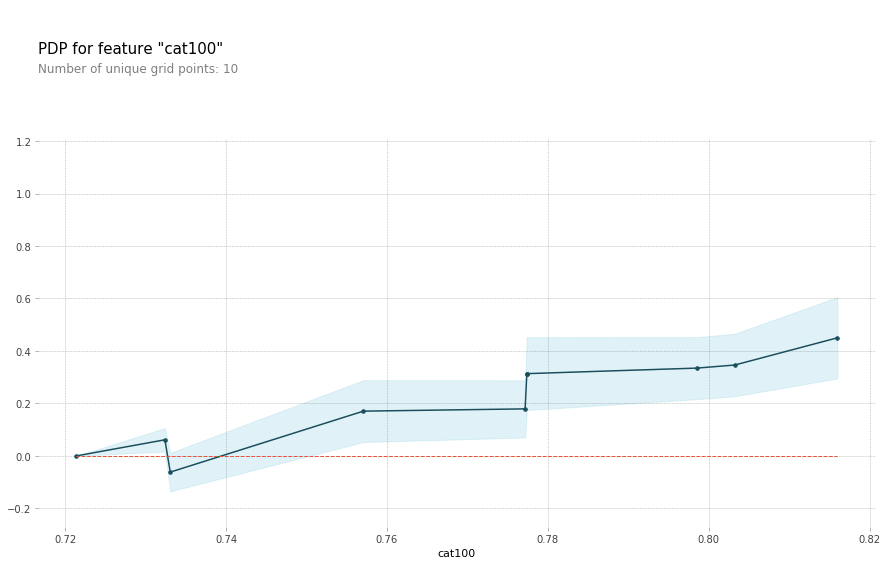

In [14]:
from matplotlib import pyplot as plt
from pdpbox import pdp, get_dataset, info_plots

# Create the data that we will plot
pdp_goals = pdp.pdp_isolate(model=gbm, dataset=X_train, model_features=X_train.columns.tolist(), feature='cat100')

# plot it
pdp.pdp_plot(pdp_goals, 'cat100')
plt.show()

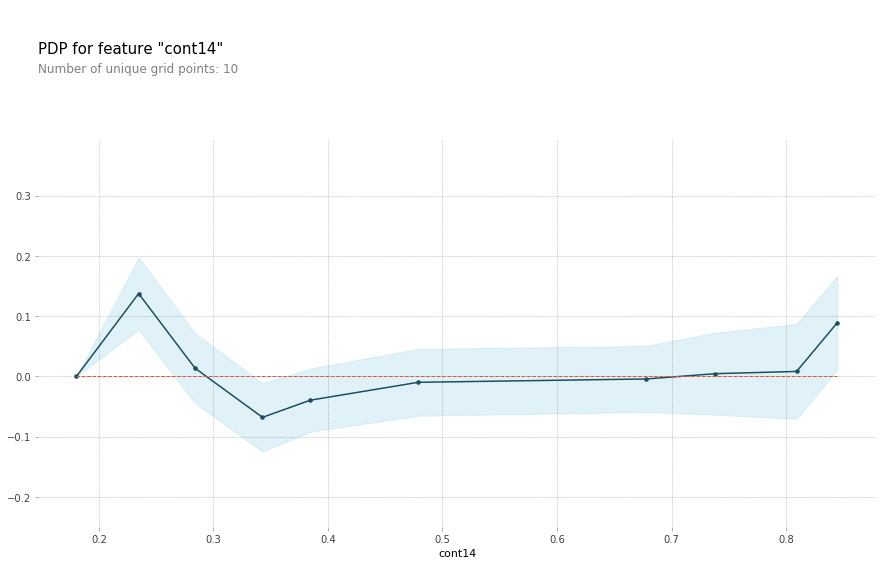

In [10]:
from matplotlib import pyplot as plt
from pdpbox import pdp, get_dataset, info_plots

# Create the data that we will plot
pdp_goals = pdp.pdp_isolate(model=gbm, dataset=X_validation, model_features=X_validation.columns.tolist(), feature='cont14')

# plot it
pdp.pdp_plot(pdp_goals, 'cont14')
plt.show()

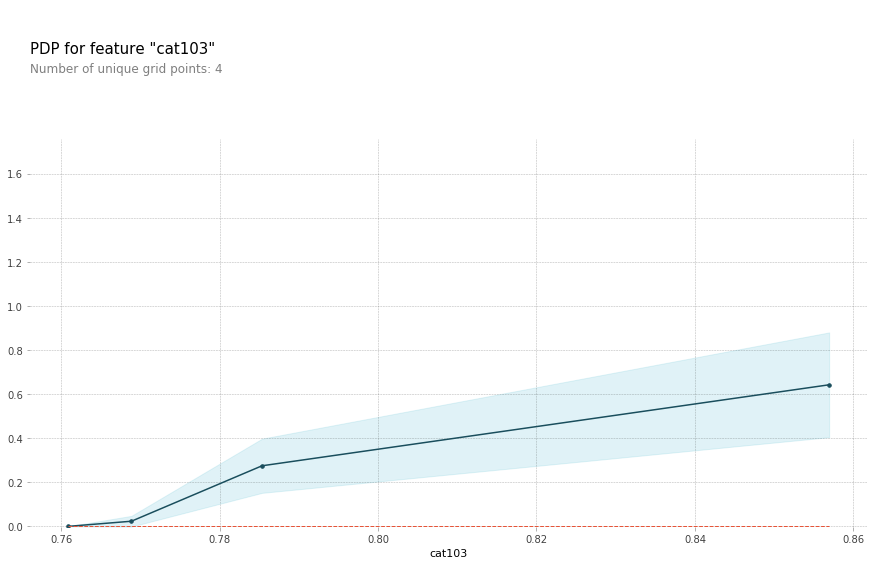

In [16]:
from matplotlib import pyplot as plt
from pdpbox import pdp, get_dataset, info_plots

# Create the data that we will plot
pdp_goals = pdp.pdp_isolate(model=gbm, dataset=X_validation, model_features=X_validation.columns.tolist(), feature='cat103')

# plot it
pdp.pdp_plot(pdp_goals, 'cat103')
plt.show()

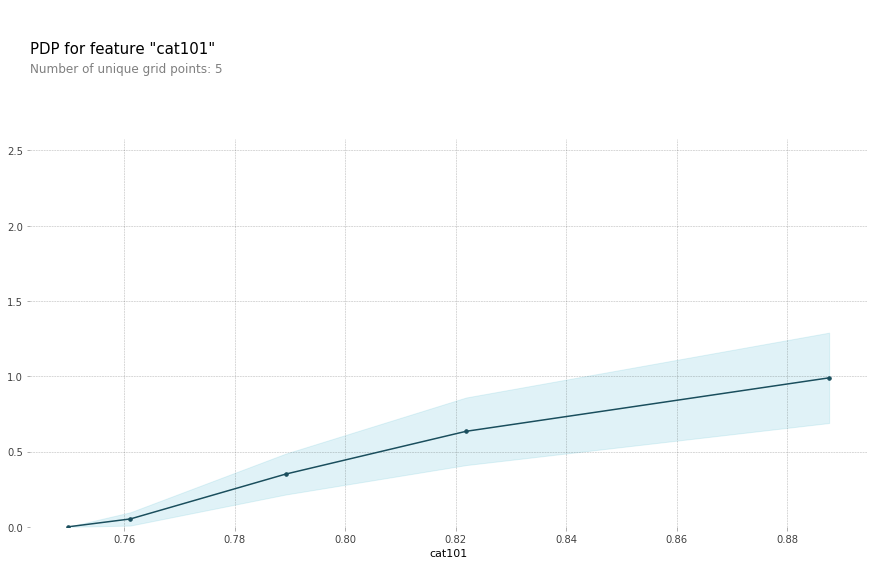

In [17]:
from matplotlib import pyplot as plt
from pdpbox import pdp, get_dataset, info_plots

# Create the data that we will plot
pdp_goals = pdp.pdp_isolate(model=gbm, dataset=X_validation, model_features=X_validation.columns.tolist(), feature='cat101')

# plot it
pdp.pdp_plot(pdp_goals, 'cat101')
plt.show()

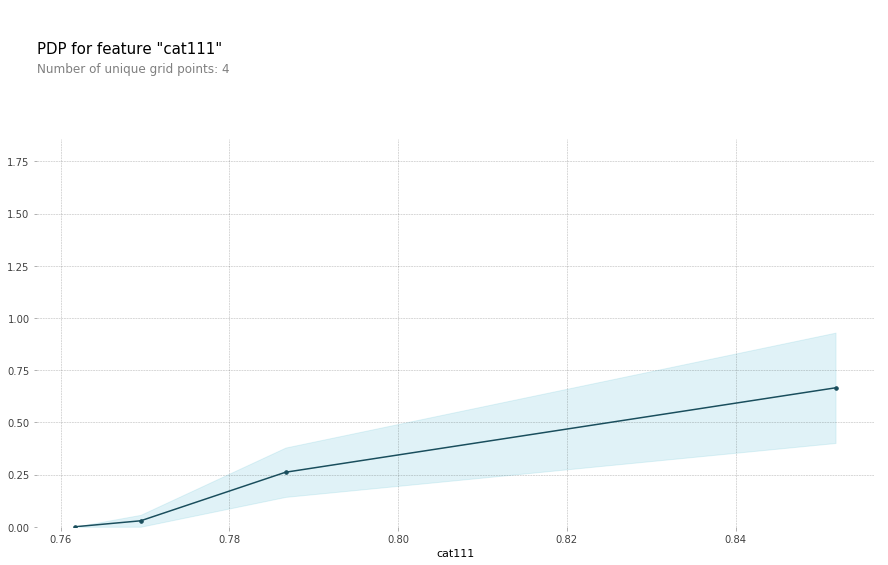

In [18]:
from matplotlib import pyplot as plt
from pdpbox import pdp, get_dataset, info_plots

# Create the data that we will plot
pdp_goals = pdp.pdp_isolate(model=gbm, dataset=X_validation, model_features=X_validation.columns.tolist(), feature='cat111')

# plot it
pdp.pdp_plot(pdp_goals, 'cat111')
plt.show()

In [10]:
pd.DataFrame(list(zip(X_train.columns,gbm.feature_importance())),columns=['feats','score']).sort_values('score',
                                                                                                       ascending=False).head(5)

,feats,score
14,cat100,14354
39,cont14,10035
16,cat103,9086
15,cat101,8604
23,cat111,8519


In [19]:
# This part can print out the p-values for the variables

import statsmodels.api as sm
import statsmodels.formula.api as smf
results = smf.OLS(Y_train,X_train).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   loss   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                 4.641e+05
Date:                Sun, 21 Apr 2019   Prob (F-statistic):               0.00
Time:                        18:41:18   Log-Likelihood:            -1.2171e+05
No. Observations:              126173   AIC:                         2.435e+05
Df Residuals:                  126133   BIC:                         2.439e+05
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
cat2           4.1308      0.240     17.194      0.0

In [20]:
X_train.cat103.value_counts()

0.760898    83005
0.768871    22267
0.785361    11067
0.804282     5241
0.814453     2969
0.831153     1025
0.840441      350
0.844420      124
0.856947       78
0.848350       27
0.829643       12
0.807726        8
Name: cat103, dtype: int64